# Evaluation on Synthetic Data

In [1]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import pandas as pd

import pyro

from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

<IPython.core.display.Javascript object>

In [3]:
import muvi

<IPython.core.display.Javascript object>

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7fd843925670>


<IPython.core.display.Javascript object>

In [5]:
# plotting settings
sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

<IPython.core.display.Javascript object>

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
try:
    gpu_idx = muvi.get_free_gpu_idx()
    print("Using GPU #%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU #1


<IPython.core.display.Javascript object>

First, lets generate some multi-view synthetic data. The dataset comprises 200 samples and four views, each having 400 features. In addition, the underlying relationships across views consist of 2 factors shared among all views, 14 factors shared among a subset of two or three views, as well as a private factor for each view. Finally, we may introduce additional covariates that can be modelled jointly during training.

In [7]:
seed = 123
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]
n_covariates = 0

<IPython.core.display.Javascript object>

In [8]:
dg = muvi.DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed, all_combs=True)

# center data
dg.normalise(with_std=False)

2023-03-20 18:08:12,769 - muvi.core.synthetic - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.
2023-03-20 18:08:12,771 - muvi.core.synthetic - WARNING - Generating all possible binary combinations of 4 variables.
2023-03-20 18:08:12,772 - muvi.core.synthetic - WARNING - New factor configuration: 1 fully shared, 10 partially shared, 4 private factors.


<IPython.core.display.Javascript object>

In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<IPython.core.display.Javascript object>

<AxesSubplot: >

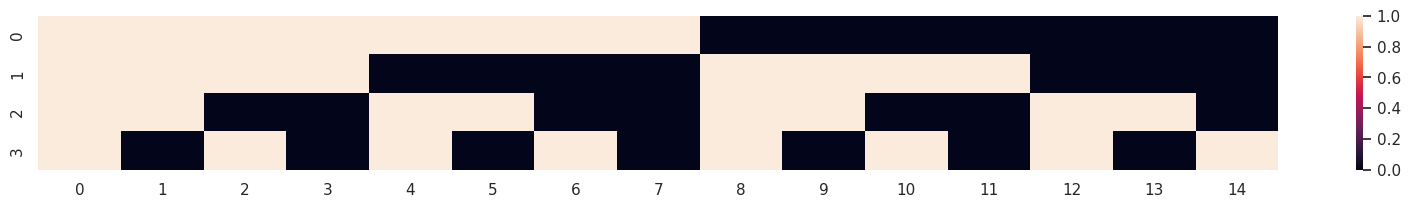

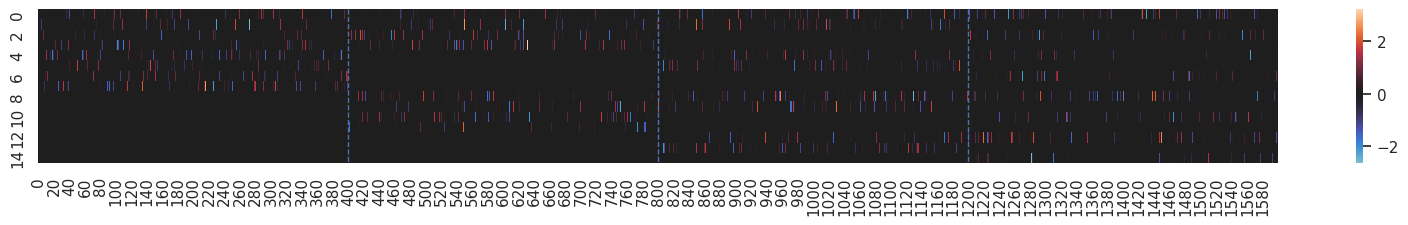

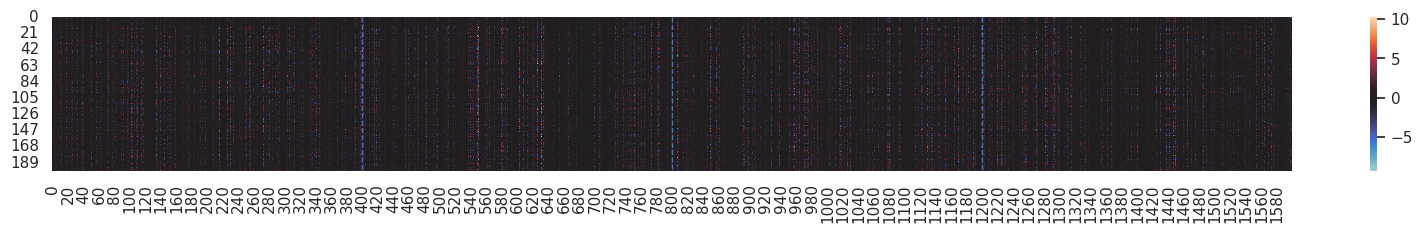

<IPython.core.display.Javascript object>

In [10]:
# factor loadings should be fairly sparse
muvi.pl.lined_heatmap(dg.view_factor_mask)
muvi.pl.lined_heatmap(dg.w, vlines=vlines, center=0)
muvi.pl.lined_heatmap(dg.y, vlines=vlines, center=0)

Now we can perturb the true underlying mask of the factor loadings in order to inform the model noisy feature sets. We do so by introducing false positives and false negatives controlled by a `noise_fraction` parameter. We may also determine which views we would like to inform via `informed_views`, a list of view indices. Here we only inform the first view (index 0).

2023-03-20 18:08:16,224 - muvi.core.synthetic - WARNING - Factor 8 is completely off, inserting 8.88%% false positives.
2023-03-20 18:08:16,225 - muvi.core.synthetic - WARNING - Factor 9 is completely off, inserting 8.88%% false positives.
2023-03-20 18:08:16,225 - muvi.core.synthetic - WARNING - Factor 10 is completely off, inserting 8.88%% false positives.
2023-03-20 18:08:16,226 - muvi.core.synthetic - WARNING - Factor 11 is completely off, inserting 8.88%% false positives.
2023-03-20 18:08:16,227 - muvi.core.synthetic - WARNING - Factor 12 is completely off, inserting 8.88%% false positives.
2023-03-20 18:08:16,227 - muvi.core.synthetic - WARNING - Factor 13 is completely off, inserting 8.88%% false positives.
2023-03-20 18:08:16,228 - muvi.core.synthetic - WARNING - Factor 14 is completely off, inserting 8.88%% false positives.


<AxesSubplot: >

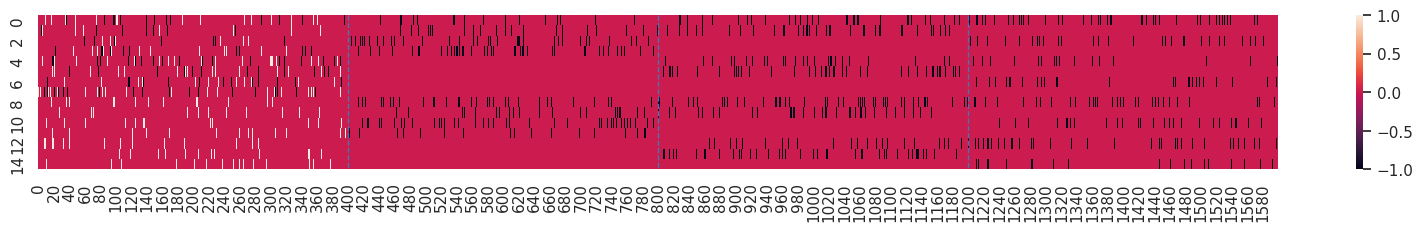

<IPython.core.display.Javascript object>

In [11]:
# perturb
noise_fraction = 0.5
# inform only first view with noisy prior
informed_views = [0]

_ = dg.get_noisy_mask(
    rng,
    noise_fraction=noise_fraction,
    informed_view_indices=informed_views,
)

# false positives and false negatives
muvi.pl.lined_heatmap(dg.noisy_w_mask - dg.w_mask, vlines=vlines)

Now that we generated a noisy version of the true factor loadings mask, we need to inform our model by relaxing the binary prior information to values larger than zero for the slab widths of the regularized horseshoe. We do so by providing a `prior_confidence` that ranges from 0 to 1 when adding the prior mask. The `prior_confidence` encodes our prior belief regarding the (noisy) prior information. A weak belief corresponds to values around 0.95 and strong to 0.99 or larger (closer to 1.0). As a rule of thumb, a `prior_confidence` of around 0.97 provides the best results on average.

In [12]:
# create an instance of the model
model = muvi.MuVI(
    dg.ys,
    prior_masks=dg.noisy_w_masks,
    covariates=dg.x,
    prior_confidence=0.97,
    use_gpu=True,
)

2023-03-20 18:08:17,407 - muvi.core.models - WARNING - No view names provided!
2023-03-20 18:08:17,409 - muvi.core.models - INFO - Setting the name of each view to `view_idx` for list observations.
2023-03-20 18:08:17,410 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2023-03-20 18:08:17,411 - muvi.core.models - INFO - Setting the name of each feature in `view_0` to `view_0_feature_idx`.
2023-03-20 18:08:17,412 - muvi.core.models - INFO - Setting the name of each feature in `view_1` to `view_1_feature_idx`.
2023-03-20 18:08:17,413 - muvi.core.models - INFO - Setting the name of each feature in `view_2` to `view_2_feature_idx`.
2023-03-20 18:08:17,414 - muvi.core.models - INFO - Setting the name of each feature in `view_3` to `view_3_feature_idx`.
2023-03-20 18:08:17,418 - muvi.core.models - INFO - Likelihoods set to `{'view_0': 'normal', 'view_1': 'normal', 'view_2': 'normal', 'view_3': 'normal'}`.
2023-03-20 18:08:17,472 - muvi.core.models - INFO - GPU av

<IPython.core.display.Javascript object>

Now we can train our model via a (stochastic) variational inference algorithm. We may also provide additional callbacks during training such as `EarlyStoppingCallback` for terminating the optimization procedure when the ELBO improvements are insignificant, or `LogCallback` for keeping track of relevant metric scores and how they progress during training.

In [13]:
# set number of epochs
n_epochs = 10000

# this callback logs metrics of the training every X steps to better gauge the training progress
log_callback = muvi.LogCallback(
    model,
    n_epochs,
    n_checkpoints=10,
    # pass true masks
    masks={vn: dg.w_masks[m].astype(bool) for m, vn in enumerate(model.view_names)},
    binary_scores_at=500,
    threshold=0.1,
    log=True,
    log_frequency=10,
    n_annotated=model.n_factors,
    informed_views=informed_views,
)

<IPython.core.display.Javascript object>

In [14]:
model.fit(
    batch_size=n_samples,
    n_epochs=n_epochs,
    n_particles=20,
    learning_rate=0.01,
    optimizer="clipped",
    verbose=1,
    seed=seed,
    callbacks=[
        log_callback,
        muvi.EarlyStoppingCallback(
            n_epochs, window_size=10, tolerance=1e-5, patience=10
        ),
    ],
)

2023-03-20 18:08:17,495 - muvi.core.models - INFO - Using 20 particles in parallel.
2023-03-20 18:08:17,496 - muvi.core.models - INFO - Preparing model and guide...
2023-03-20 18:08:18,921 - muvi.core.models - INFO - Preparing optimizer...
2023-03-20 18:08:18,925 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2023-03-20 18:08:18,927 - muvi.core.models - INFO - Preparing SVI...
2023-03-20 18:08:18,929 - muvi.core.models - INFO - Preparing training data...
2023-03-20 18:08:18,965 - muvi.core.models - INFO - Using complete dataset.
2023-03-20 18:08:18,968 - muvi.core.models - INFO - Setting training seed to `123`.
2023-03-20 18:08:18,970 - muvi.core.models - INFO - Cleaning parameter store.
2023-03-20 18:08:18,974 - muvi.core.models - INFO - Starting training...


  0%|                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

2023-03-20 18:08:19,631 - root - INFO - Guessed max_plate_nesting = 3


 10%|█████████████████▌                                                                                                                                                              | 998/10000 [00:36<04:53, 30.69it/s, ELBO=728]

Average fraction of inactive loadings:
view_0: 0.953, view_1: 0.947, view_2: 0.938, view_3: 0.949
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
`view_name`: (prec, rec, f1)
view_0: (0.996, 0.996, 0.996)
2023-03-20 18:08:55,139 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


 10%|█████████████████▌                                                                                                                                                             | 1002/10000 [00:36<06:18, 23.78it/s, ELBO=727]

RMSE for each view:
view_0: 0.322, view_1: 0.351, view_2: 0.313, view_3: 0.316
Variance explained for each view:
view_0: 0.875, view_1: 0.813, view_2: 0.893, view_3: 0.882


 20%|███████████████████████████████████                                                                                                                                            | 2001/10000 [01:09<05:53, 22.63it/s, ELBO=701]

Average fraction of inactive loadings:
view_0: 0.951, view_1: 0.950, view_2: 0.944, view_3: 0.952
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
`view_name`: (prec, rec, f1)
view_0: (0.969, 1.000, 0.984)
RMSE for each view:
view_0: 0.322, view_1: 0.321, view_2: 0.313, view_3: 0.316
Variance explained for each view:
view_0: 0.875, view_1: 0.881, view_2: 0.893, view_3: 0.881


 28%|█████████████████████████████████████████████████▌                                                                                                                             | 2830/10000 [01:37<04:06, 29.04it/s, ELBO=699]

Relative improvement of -0.0001049 < 1e-05 for 10 step(s) in a row, stopping early.
2023-03-20 18:09:56,450 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<IPython.core.display.Javascript object>

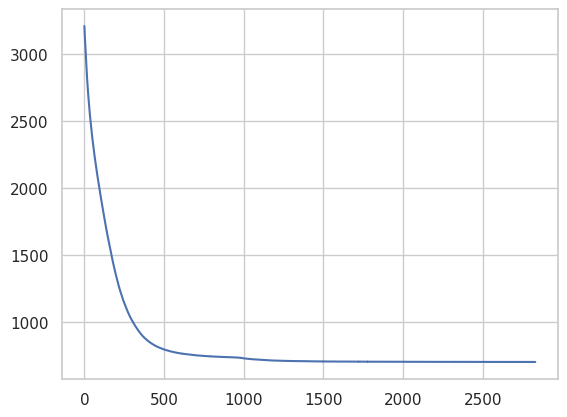

<IPython.core.display.Javascript object>

In [15]:
# plot the ELBO across epochs
plt.plot(model._training_log["history"])

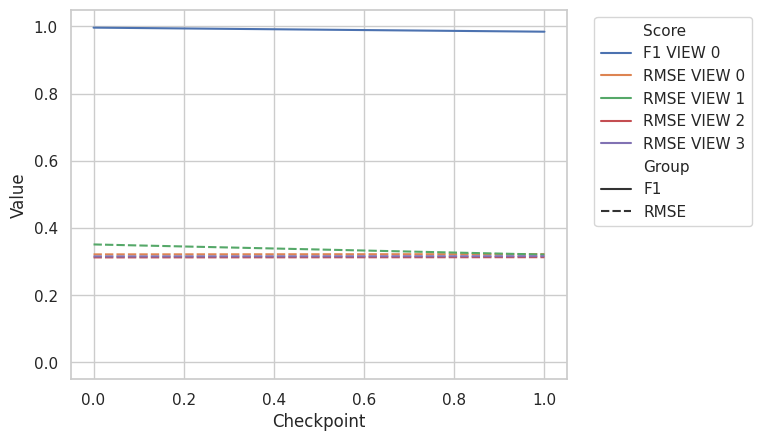

<IPython.core.display.Javascript object>

In [16]:
df = pd.DataFrame(log_callback.scores)
df["checkpoint"] = df.index
df = pd.melt(df, id_vars=["checkpoint"], value_vars=df.columns[:-1])
df.columns = ["Checkpoint", "Score", "Value"]
df["Score"] = df["Score"].map(lambda s: " ".join([p.upper() for p in s.split("_")]))
df["Group"] = df["Score"].str.split(" ").str[0]


g = sns.lineplot(
    data=df[df["Score"].str.contains("RMSE|F1")],
    x="Checkpoint",
    y="Value",
    hue="Score",
    style="Group",
)
g.set(ylim=(-0.05, 1.05))
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [25]:
# overall RMSE
mean_squared_error(
    dg.y,
    np.concatenate([model.get_predicted()[vn] for vn in model.view_names], 1),
    squared=False,
)

0.3185216711245128

<IPython.core.display.Javascript object>

Once the training converges, we may inspect the learned parameters and compare them to the true parameters.

<AxesSubplot: >

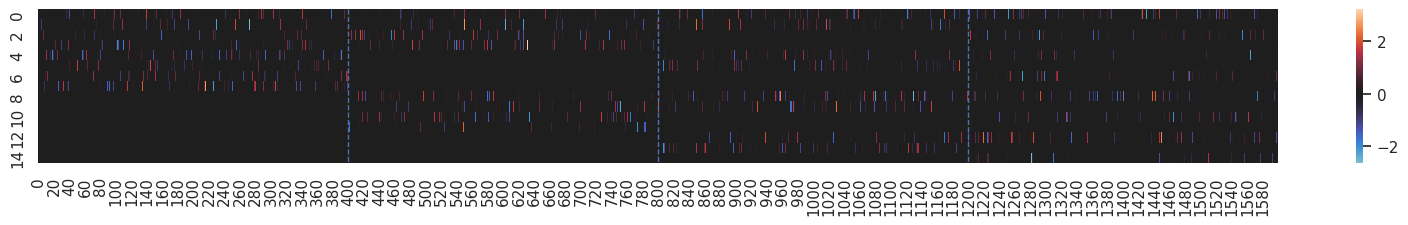

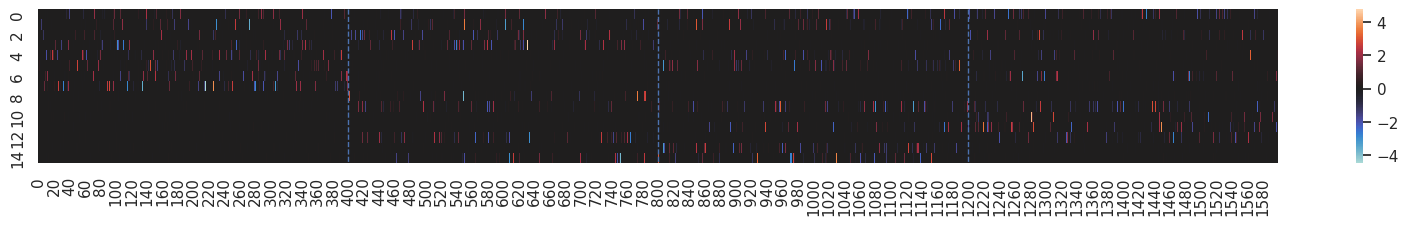

<IPython.core.display.Javascript object>

In [18]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)

muvi.pl.lined_heatmap(dg.w, vlines=vlines, center=0)
muvi.pl.lined_heatmap(approx_w, vlines=vlines, center=0)

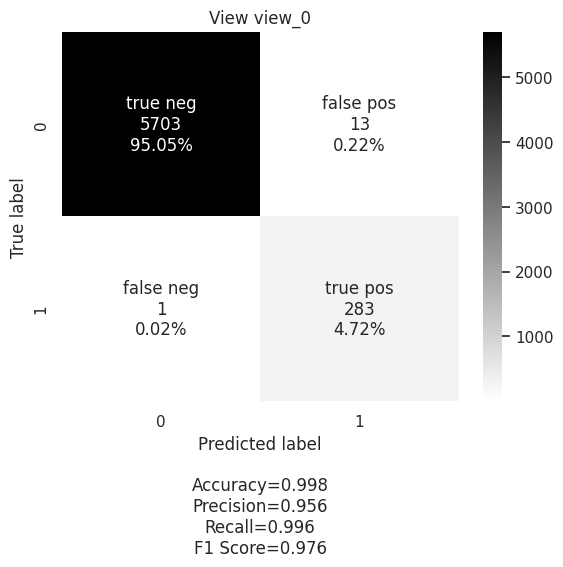

<IPython.core.display.Javascript object>

In [19]:
threshold = 0.1
# plot the confusion matrix between the true loadings activity and the learned loadings activity for the informed views
for m in informed_views:
    _ = muvi.pl.confusion_matrix(model, model.view_names[m], true_mask=dg.w_masks[m])
    plt.show()

Due to non-identifiability of FA models, it is sometimes necessary to permute the order of the factors match the true order. We do so by first computing the cosine similarities between the true factor loadings mask and the learned factor loading activations (based on a threshold). Then, we find the optimal permutation by matching each factor with its corresponding true factor index based on the largest cosine similarity.

<AxesSubplot: >

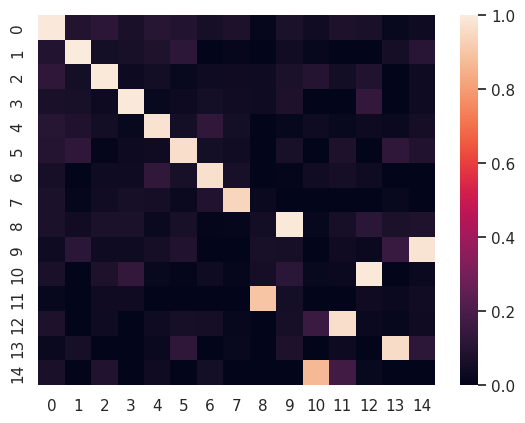

<IPython.core.display.Javascript object>

In [20]:
cos_sim = cosine_similarity(dg.w_mask, np.abs(approx_w) > threshold)
sns.heatmap(cos_sim, annot=False)

<AxesSubplot: >

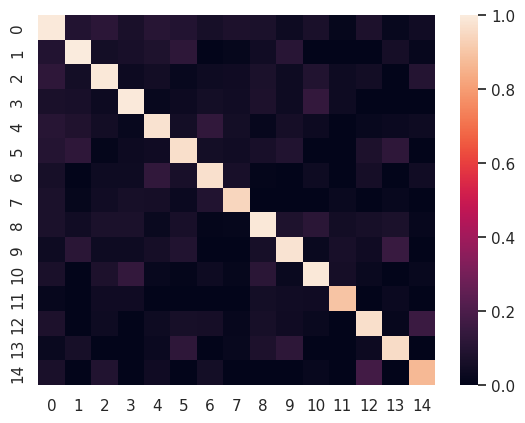

<IPython.core.display.Javascript object>

In [21]:
opt_order = muvi.tl.optim_perm(cos_sim).argmax(axis=0)
sns.heatmap(cos_sim[:, opt_order], annot=False)

Our model also infers the relationship across subsets of views by learning a set of `factor_scales` for each view. The lower the value of a factor scale $k$ in view $m$, the less significant this factor is for view $m$.

In [22]:
factor_scales = model._guide.get_factor_scale()[:, opt_order]
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]

<IPython.core.display.Javascript object>

<AxesSubplot: >

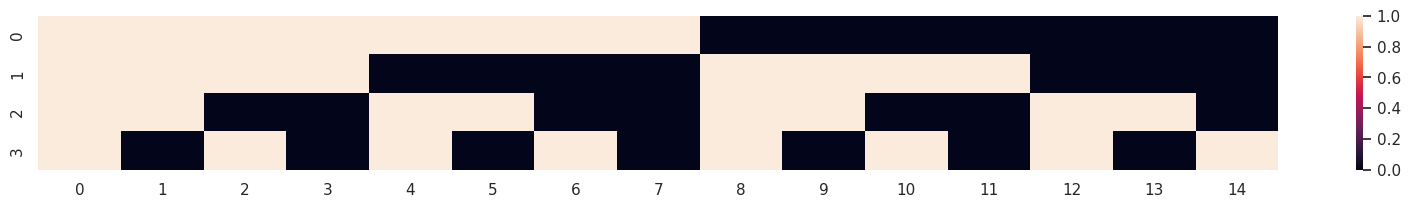

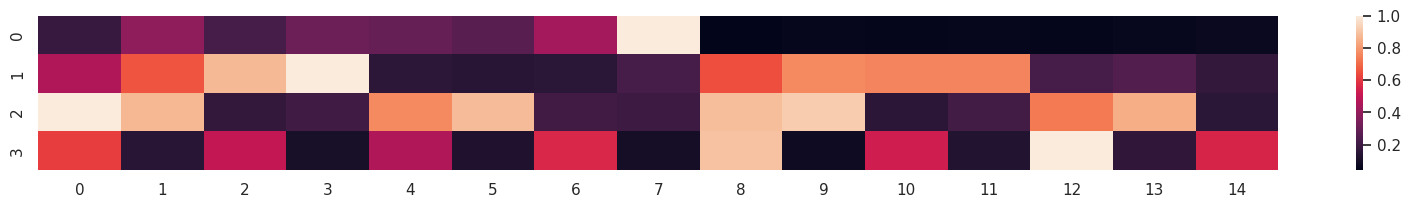

<IPython.core.display.Javascript object>

In [23]:
muvi.pl.lined_heatmap(dg.view_factor_mask)
muvi.pl.lined_heatmap(factor_scales)

We can also go one level deeper and inspect a single factors by extractin its factor loadings and plotting the sorted weights along with their corresponding state, one of true positive (TP), true negative (TN), false positive (FP) and false negative (FN). Ideally we would like to see true active loadings away from zero, i.e. true positives (TP), false negatives (FN), and true inactive loadings close to zero, i.e. false positives (FP), true negatives (TN)

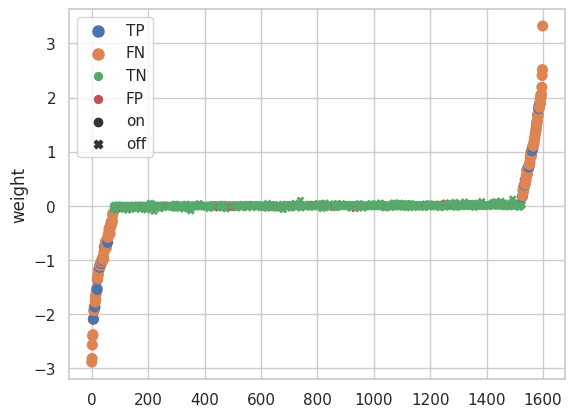

<IPython.core.display.Javascript object>

In [24]:
g, _ = muvi.pl.factor_activity(
    dg.w, approx_w[opt_order, :], dg.w_mask, dg.noisy_w_mask, factor_idx=0
)

Take a look at [this notebook](2_single-cell_rna-seq.ipynb) for a standard application of `MuVI` on a single-cell RNA-seq dataset of peripheral blood mononuclear cells (PBMCs) from lupus patients.